In [80]:
from src.diamonds_data import DiamondsData
from src.transform_toolbox import label_encode_data, normalize_data_pipeline, export_to_kaggle_csv
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from math import sqrt
import numpy as np
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, DMatrix

import pandas as pd
import matplotlib.pyplot as plt


# Cargo los ficheros del csv

In [2]:
diamonds_train_df = DiamondsData("input/train.csv")
X = diamonds_train_df.get_features()
y = diamonds_train_df.get_groundtruth()

# Transformación y preprocesado de datos

In [3]:
# Voy a transformar las columnas "cut", "color" y "clarity" en numéricas, usando LabelEncoder.
object_columns = ["cut", "color", "clarity"]
X_label_encoded = label_encode_data(X, object_columns)

# Comprobamos que las columnas "cut", "color" y "clarity" ya son numéricas:
X_label_encoded.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.12,3,4,2,61.6,59.0,6.67,6.63,4.10
1,1.14,4,1,3,60.0,54.0,6.74,6.97,4.11
2,0.90,4,0,3,60.3,63.0,6.12,6.22,3.72
3,0.71,2,1,4,61.9,54.0,5.74,5.76,3.56
4,0.34,4,2,3,60.0,62.0,4.51,4.55,2.72


In [4]:
# Transformaciones que uso:
# - StandardScaler: hago que la media de todas las columnas sea 0 y la desviación típica sea 1.

pipeline_transforms = [
    StandardScaler(),
    #Normalizer(), # Si aplico el Normalizer() las métricas empeoran
    #PCA(n_components = 9),
] 

# En esta función aplico una pipeline para transformar los datos
X_normalized = normalize_data_pipeline(X_label_encoded, pipeline_transforms)

# Resultado de las 5 primeras filas tras la normalización
display(X_normalized.head())

# Compruebo que tras la transformación la media y standar deviation de una de las columnas es prácticamente 0 y 1 respectivamente:
#print(X_normalized["carat"].mean())
#print(X_normalized["carat"].std())


,carat,cut,color,clarity,depth,table,x,y,z
0,0.677821,0.436318,0.827101,-1.062198,-0.101191,0.695508,0.835699,0.776126,0.789949
1,0.719937,1.411739,-0.937780,-0.482915,-1.216763,-1.550809,0.898013,1.071048,0.804023
2,0.214540,1.411739,-1.526073,-0.482915,-1.007593,2.492562,0.346092,0.420484,0.255168
3,-0.185566,-0.539104,-0.937780,0.096368,0.107979,-1.550809,0.007818,0.021471,0.029996
4,-0.964720,1.411739,-0.349486,-0.482915,-1.216763,2.043298,-1.087121,-1.028107,-1.152153


# Separar datos de entrenamiento de datos de test

In [5]:
# Como voy a hacer cross validation no necesito separar estos datos
# X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size = 0.2)


# Evaluación de varios modelos usando Cross-Validation

In [26]:
models = {
    "svm_rbf_kernel": SVR(kernel='rbf'),
    "svm_linear_kernel": SVR(kernel='linear'),
    "svm_sigmoid_kernel": SVR(kernel='sigmoid'),
    "svm_poly_kernel": SVR(kernel='poly'),
    "linear_regression": LinearRegression(),
    "k_nearest": KNeighborsRegressor(),
    "k_nearest_v2": KNeighborsRegressor(n_neighbors=2, weights='distance', n_jobs=-1),
    "k_nearest_v3": KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=-1),
    "xgb_regressor": XGBRegressor(),
}


In [27]:
# Numero de ciclos de cross-validations
n = 5

# Para cada modelo hago n cross-validations
result = {}
for name, model in models.items():
    scores = cross_validate(model, X_normalized, y, cv = n, scoring=['neg_mean_squared_error', 'r2'])
    result[name] = scores
    

In [46]:
# Muestro las métricas para comparar las predicciones de los distintos algoritmos que he utilizado:
data_to_plot = {}

for model in result.keys():
    print("Modelo: " + model)
    
    r2_score = round(np.mean(result[model]['test_r2']), 2)
    neg_mse = np.mean(result[model]['test_neg_mean_squared_error'])
    mse = -1 * neg_mse
    root_mse = sqrt(mse)

    print("- Root Mean Squared Error: " + str(root_mse))
    print("- r2: " + str(r2_score))
    print("")
    
    data_to_plot[model] = root_mse


Modelo: svm_rbf_kernel
- Root Mean Squared Error: 2951.144869965041
- r2: 0.45

Modelo: svm_linear_kernel
- Root Mean Squared Error: 1629.796396821563
- r2: 0.83

Modelo: svm_sigmoid_kernel
- Root Mean Squared Error: 2414.4398969241315
- r2: 0.63

Modelo: svm_poly_kernel
- Root Mean Squared Error: 7018.47852657479
- r2: -2.02

Modelo: linear_regression
- Root Mean Squared Error: 1361.0798965333202
- r2: 0.88

Modelo: k_nearest
- Root Mean Squared Error: 843.4036938481404
- r2: 0.96

Modelo: k_nearest_v2
- Root Mean Squared Error: 862.7330496112778
- r2: 0.95

Modelo: k_nearest_v3
- Root Mean Squared Error: 803.8904170647687
- r2: 0.96

Modelo: xgb_regressor
- Root Mean Squared Error: 560.9452299291538
- r2: 0.98



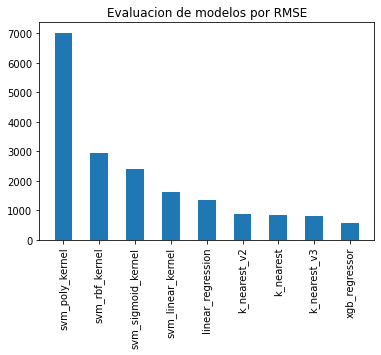

In [79]:
data_to_plot = {k: v for k, v in sorted(data_to_plot.items(), reverse=True, key=lambda item: item[1])}

models = list(data_to_plot.keys()) 
rmse = list(data_to_plot.values()) 

plt.bar(models, rmse, width = 0.5)
plt.xticks(models, rotation='vertical')
plt.title("Evaluacion de modelos por RMSE")

plt.show();

# El gráfico está ordenado de peor resultado (el RMSE más alto) a mejor (el RMSE más bajo).
# Como puede verse el mejor resultado es el del algoritmo XGBoost.

# Entrenamiento del modelo definitivo
De acuerdo a los resultados anteriores el modelo que ofrece una mejor predicción es X Gradient Boosting.

El siguiente paso es entrenar el modelo con todos datos y luego formatear y enviar las predicciones.

In [39]:
model = XGBRegressor()

# Cargo los datos del CSV de predicciones
diamonds_predict_df = DiamondsData("input/predict.csv")
X_predict = diamonds_predict_df.get_features()

# Hago label encode de las mismas columnas que con los datos de entrenamiento
X_predict_label_encoded = label_encode_data(X_predict, object_columns)

# Normalizo los datos con la misma pipeline que los datos de entrenamiento
X_predict_normalized = normalize_data_pipeline(X_predict_label_encoded, pipeline_transforms)

# Entrenamiento del modelo con todos los datos de TRAIN.CSV:
model.fit(X_normalized, y)

# Prediccion con los datos de PREDICT.CSV
diamond_price_prediction = model.predict(X_predict_normalized)

# Preparación de los resultados para enviar a Kaggle

In [40]:
print(diamond_price_prediction)

[ 791.1374 6061.3022 6015.245  ... 2541.3706 1140.6143 1033.5537]


In [31]:
export_to_kaggle_csv(diamonds_predict_df.get_all(), diamond_price_prediction)

Exportados los datos a: output/'prediction_20201005_190955.csv'
